In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %reload_ext autoreload

In [72]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import rectification
import utils
import constants

# Input Files

In [109]:
DATA = Path("data")
OUTDIR = Path("output")

In [110]:
name  = "car"

im1_name = DATA / (name + "1.jpg")
im2_name = DATA / (name + "2.jpg")
im3_name = DATA / (name + "3.jpg")

In [111]:
plane_name = DATA / (name + "_plane.pkl")

warp1_name = DATA / (im1_name.stem + "_w.jpg")
warp2_name = DATA / (im2_name.stem + "_w.jpg")
warp3_name = DATA / (im3_name.stem + "_w.jpg")

pts1_name = DATA / (im1_name.stem + "_w.pkl")
pts2_name = DATA / (im2_name.stem + "_w.pkl")
pts3_name = DATA / (im3_name.stem + "_w.pkl")

In [112]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

In [113]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
markers = ['o', '.', '+', 'x', '>', 'v', '^', '*', 'D']

# Pick Correspondences

In [114]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)
im3 = utils.read_img(im3_name)

In [115]:
try:
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
except:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 4)
    im2_pts = utils.pick_points(im2_name, 4)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    %matplotlib inline

In [101]:
# im1_pts = im1_pts[:4]
# im2_pts = im2_pts[:4]

In [116]:
h, w, c = im1.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print("input shape = ", im1.shape)
    print("target shape = ", h / r, w / r)

RESIZE = False


In [117]:
if RESIZE:
    print("resizing...")
    im1 = sk.transform.resize(im1, (im1.shape[0] // r, im1.shape[1] // r), anti_aliasing=True)
    im2 = sk.transform.resize(im2, (im2.shape[0] // r, im2.shape[1] // r), anti_aliasing=True)
    im1_pts /= r
    im2_pts /= r

im1.shape

(750, 1000, 3)

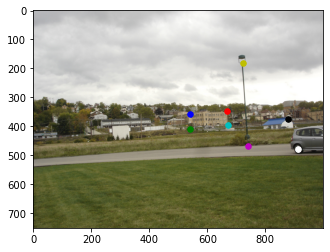

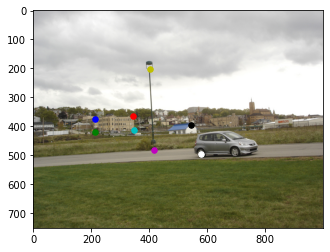

In [118]:
_ = utils.plot_points(im1, im1_pts)
_ = utils.plot_points(im2, im2_pts)

# Image Rectification

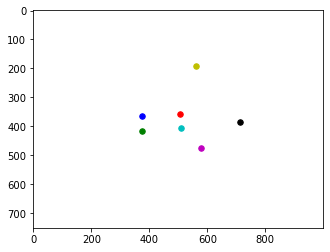

In [119]:
try:
    plane_pts = utils.load_points(plane_name)
except:
    # %matplotlib tk
    # plane_pts = utils.pick_points(im1, 4)
    # %matplotlib inline
    plane_pts = (im1_pts + im2_pts) / 2
    # utils.save_points(plane_pts, plane_name)

if RESIZE:
    plane_pts /= r

canvas = np.ones_like(im1)
_ = utils.plot_points(canvas, plane_pts)

# Warping to the same plane

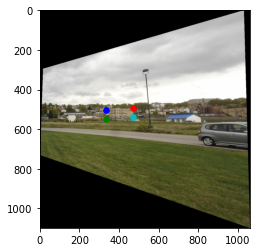

In [120]:
try:
    warp1 = utils.read_img(warp1_name)
    warp_pts1 = utils.load_points(pts1_name)

except:
    print("warping...")

    h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
    warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
    warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
    
    plt.imsave(warp1_name, warp1)
    utils.save_points(warp_pts1, pts1_name)

_ = utils.plot_points(warp1, warp_pts1)

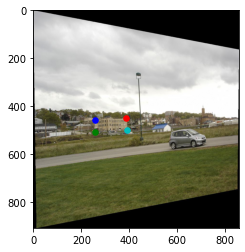

In [107]:
try:
    warp2 = utils.read_img(warp2_name)
    warp_pts2 = utils.load_points(pts2_name)

except:
    print("warping...")
    
    h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
    warp2, shift_pts2= homography.inverse_warp(im2, h_matrix2)
    warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

    plt.imsave(warp2_name, warp2)
    utils.save_points(warp_pts2, pts2_name)

_ = utils.plot_points(warp2, warp_pts2)

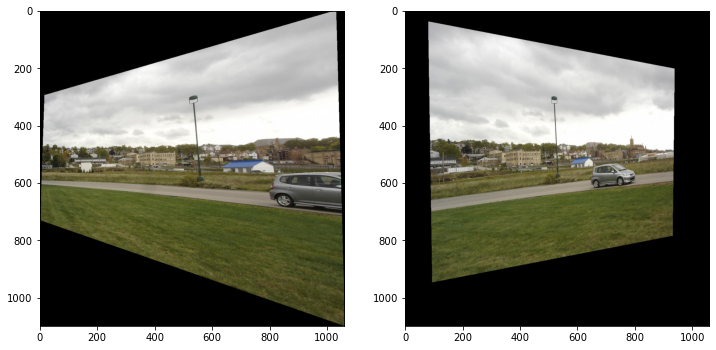

In [121]:
aligned1, aligned2, *_ = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
_ = utils.show_two(aligned1, aligned2)

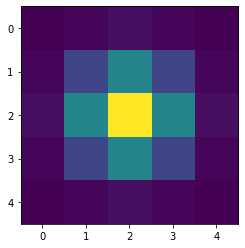

In [122]:
g = filters.gaussian_filter()
plt.imshow(g)

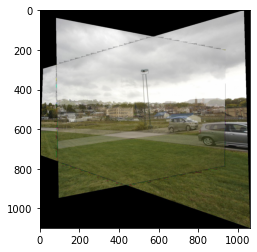

In [123]:
blended = rectification.average_blend(aligned1, aligned2)
plt.imshow(blended)

# Warp image 1 and 3 to image 2

In [124]:
# if constants.LOAD:
try:
    pts1 = utils.load_points(im1_name)
    name_a = im2_name.stem + "a" + im2_name.suffix
    name_b = im2_name.stem + "b" + im2_name.suffix
    pts2a = utils.load_points(im2_name.parent / name_a)
    pts2b = utils.load_points(im2_name.parent / name_b)
    pts3 = utils.load_points(im3_name)
    pts = [pts1, pts2a, pts2b, pts3]
    print("Loaded points for 3 images")
except:
    raise FileExistsError()
# else:
#     pts1 = utils.pick_points(im1_name, constants.NUM_PTS)
#     pts2a = utils.pick_points(im2_name, constants.NUM_PTS)
#     pts2b = utils.pick_points(im2_name, constants.NUM_PTS)
#     pts3 = utils.pick_points(im3_name, constants.NUM_PTS)
#     pts = [pts1, pts2a, pts2b, pts3]
#     if constants.SAVE:
#         print("Saving points")
#         pts1 = utils.save_points(pts1, args.images[0])
#         name_a = args.images[1].stem + "a" + args.images[1].suffix
#         name_b = args.images[1].stem + "b" + args.images[1].suffix
#         pts2a = utils.save_points(pts2a, args.images[1].parent / name_a)
#         pts2b = utils.save_points(pts2b, args.images[1].parent / name_b)
#         pts3 = utils.save_points(pts3, args.images[2])

Loaded points for 3 images


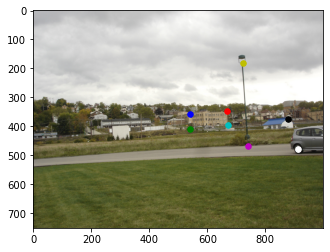

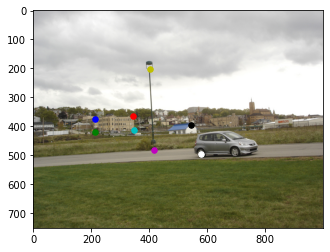

In [125]:
_ = utils.plot_points(im1 , pts1)
_ = utils.plot_points(im2 , pts2a)

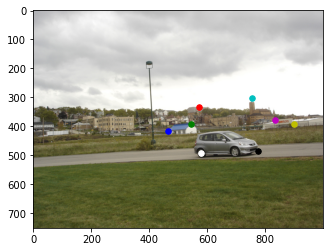

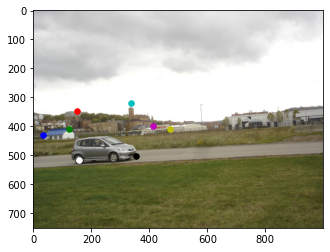

In [126]:
_ = utils.plot_points(im2 , pts2b)
_ = utils.plot_points(im3 , pts3)

Warp image 1 to image 2


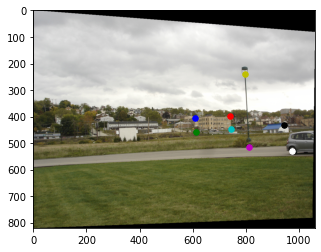

In [127]:
# warp image 1
print("Warp image 1 to image 2")
H1 = homography.homo_matrix(pts1, pts2a)
warp1, shift1 = homography.inverse_warp(im1, H1)
warp1_pts = homography.warp_pts(pts1, H1, shift1)
_ = utils.plot_points(warp1, warp1_pts)

In [128]:
# no need to warp image 2
warp2, warp2_pts = im2, pts2a

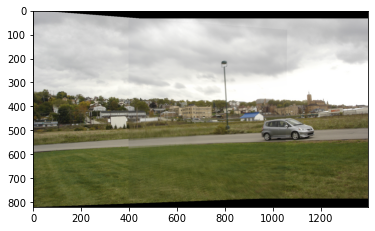

In [129]:
# Align and blend image 1 and 2
aligned1, aligned2, _, _, _, shift2 = rectification.align(
    warp1, warp2, warp1_pts, warp2_pts
)
blend_12 = rectification.blend(aligned1, aligned2, method=constants.BLEND_METHOD)
plt.imshow(blend_12)


Warp image 3 to image 2


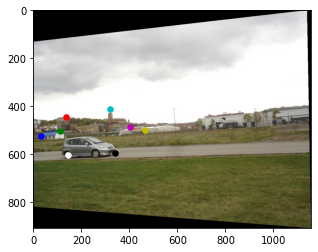

In [130]:
print("Warp image 3 to image 2")
pts2b += shift2
H3 = homography.homo_matrix(pts3, pts2b)
warp3, shift3 = homography.inverse_warp(im3, H3)
warp3_pts = homography.warp_pts(pts3, H3, shift3)
_ = utils.plot_points(warp3, warp3_pts)

Align and blend with image 3


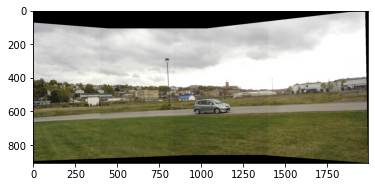

In [131]:
print("Align and blend with image 3")
aligned12, aligned3, *_ = rectification.align(blend_12, warp3, pts2b, warp3_pts)
blend_123 = rectification.blend(aligned12, aligned3, method=constants.BLEND_METHOD)
plt.imshow(blend_123)